# Importing Libraries


In [1]:
import pickle
import numpy as np
import pandas as pd
import tensorflow as tf
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split
from scipy.spatial.distance import cdist
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import Adam
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression,OrthogonalMatchingPursuit, OrthogonalMatchingPursuit,  Lasso, Ridge
from sklearn.svm import SVR
from sklearn.tree import DecisionTreeRegressor
from tensorflow.keras import layers
from tensorflow import keras
import statsmodels.api as sm
from sklearn.ensemble import RandomForestRegressor


import warnings
warnings.filterwarnings('ignore')

In [2]:
%matplotlib inline

# Loading the data

In [3]:
file_path = "data/Sensor_Data.xlsx"

dfs = []

with pd.ExcelFile(file_path) as xlsx:
    for sheet_name in xlsx.sheet_names:
        df = pd.read_excel(xlsx, sheet_name)
        dfs.append(df)

combined_df = df = pd.concat(dfs, ignore_index=True)
df = combined_df.copy()
df["Irradiance(W/m2)"] = df["Light Intensity(lumens)"]*0.079
df["Timestamp"] = pd.to_datetime(df["Timestamp"])
m = {}

for i in range(0,len(df)):
    key = f"{df.iloc[i]['Timestamp'].day}-{df.iloc[i]['Timestamp'].month}"
    if key in m:
        m[key][1] += 1
        
    else:
        m[key] = [i, i]
        
m

mod_df = pd.DataFrame(columns= ["Timestamp", "Temperature(Â°C)", "Irradiance(W/m2)", "Power(Watts)"])

for i in m:
    temp = sum(df.iloc[m[i][0]:(m[i][1] + 1)]["Temperature(Â°C)"]) / (m[i][1] + 1 - m[i][0])
    irr = sum(df.iloc[m[i][0]:(m[i][1] + 1)]["Irradiance(W/m2)"]) / (m[i][1] + 1 - m[i][0])
    power = sum(df.iloc[m[i][0]:(m[i][1] + 1)]["Power(Watts)"]) / (m[i][1] + 1 - m[i][0])
    time = df.iloc[m[i][0]]["Timestamp"]

    mod_df = mod_df.append({"Timestamp": time, "Temperature(Â°C)":temp, "Irradiance(W/m2)":irr, "Power(Watts)": power }, ignore_index = True)

        
df  = mod_df.copy()

In [4]:
m

{'23-2': [0, 2106],
 '24-2': [2107, 3743],
 '25-2': [3744, 5963],
 '27-2': [5964, 6631],
 '28-2': [6632, 9015],
 '1-3': [9016, 10538],
 '2-3': [10539, 12126],
 '3-3': [12127, 13030],
 '13-3': [13031, 15235],
 '14-3': [15236, 16542],
 '15-3': [16543, 18680],
 '16-3': [18681, 20433],
 '17-3': [20434, 22159],
 '18-3': [22160, 22929],
 '20-3': [22930, 24960],
 '21-3': [24961, 26592],
 '22-3': [26593, 28776],
 '23-3': [28777, 30365],
 '27-3': [30366, 32254],
 '28-3': [32255, 34433]}

In [5]:
results = pd.DataFrame(columns=["Model_name", "RMSE"])

# Radial basis Neural Network

In [16]:


X = df[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df["Power(Watts)"].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

class RBFNet(object):
    def __init__(self, input_dim, hidden_dim, output_dim, sigma=1.0):
        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.output_dim = output_dim
        self.sigma = sigma
        self.centers = None
        self.weights = None
        
    def _gaussian(self, x, center):
        return np.exp(-self.sigma*np.linalg.norm(x-center)**2)
    
    def _design_matrix(self, X):
        dist = cdist(X, self.centers)
        return np.array([self._gaussian(X[i], self.centers[j]) for i in range(len(X)) for j in range(len(self.centers))]).reshape((len(X), len(self.centers)))
    
    def fit(self, X, y):
        from sklearn.cluster import KMeans
        kmeans = KMeans(n_clusters=self.hidden_dim, random_state=0).fit(X)
        self.centers = kmeans.cluster_centers_
        phi = self._design_matrix(X)
        self.weights = np.linalg.lstsq(phi, y, rcond=None)[0]
        
    def predict(self, X):
        phi = self._design_matrix(X)
        y_pred = np.dot(phi, self.weights)
        return y_pred
    
    def summary(self):
        print("RBFNet Model Summary")
        print("--------------------")
        print(f"Input Dimension: {self.input_dim}")
        print(f"Hidden Dimension: {self.hidden_dim}")
        print(f"Output Dimension: {self.output_dim}")
        print(f"Sigma: {self.sigma}")

input_dim = 2
hidden_dim = 6
output_dim = 1
sigma = 1.0

rbfnet = RBFNet(input_dim, hidden_dim, output_dim, sigma)


rbfnet.fit(X_train, y_train)


y_pred = rbfnet.predict(X_test)

mse_1 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_1:.10f}')
print(f'\n')
rbfnet.summary()

Mean Squared Error: 0.0086564984


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 6
Output Dimension: 1
Sigma: 1.0


In [17]:
y_pred = rbfnet.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = rbfnet.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
rbfnet.summary()

Test Root Mean Squared Error: 9.0810394685
Train Root Mean Squared Error: 16.1313676214


RBFNet Model Summary
--------------------
Input Dimension: 2
Hidden Dimension: 6
Output Dimension: 1
Sigma: 1.0


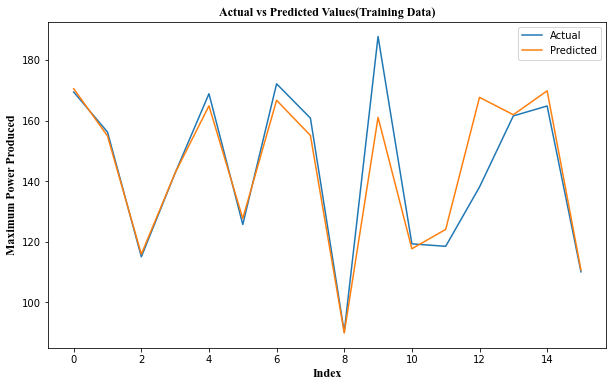

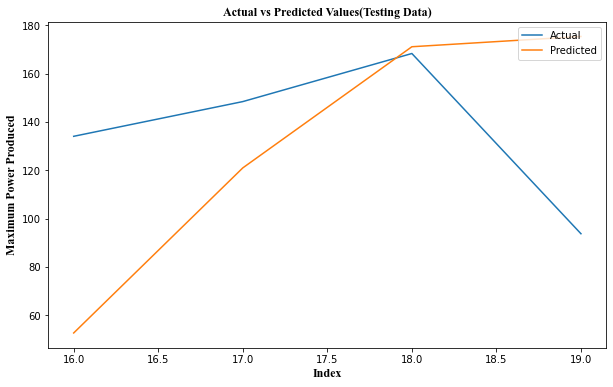

In [58]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


In [59]:
results = results.append({"Model_name":"Radial Basis Function Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905


# LSTM

In [60]:
train_size = int(len(df) * 0.8)
train_data = df[:int(0.8 * len(df))].copy()
test_data = df[int(0.8 * len(df)):].copy()

scaler = MinMaxScaler()
train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.fit_transform(train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
train_data = train_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()
test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']] = scaler.transform(test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']])
test_data = test_data[['Temperature(Â°C)', "Irradiance(W/m2)", 'Power(Watts)']].copy()

time_steps = 2

def create_sequences(dated_data, time_steps):
    X = []
    y = []
    for i in range(len(dated_data) - time_steps):        
        X.append(dated_data.iloc[i:i + time_steps, :2].values)
        y.append(dated_data.iloc[i + time_steps, 2])
    return np.array(X), np.array(y)

X_train, y_train = create_sequences(train_data, time_steps)
X_test, y_test = create_sequences(test_data, time_steps)

X_train = X_train.reshape(-1, time_steps, 2)
X_test = X_test.reshape(-1, time_steps, 2)



model = Sequential()
model.add(LSTM(64, input_shape=(X_train.shape[1], X_train.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(32))
model.add(Dropout(0.2))
model.add(Dense(1))

model.compile(loss='mse', optimizer=Adam(lr=0.01))
history = model.fit(X_train, y_train, epochs=50, batch_size=32, verbose=1, validation_data=(X_test, y_test))

Epoch 1/50
1/1 [==============================] - 7s 7s/step - loss: 0.3605 - val_loss: 0.2651
Epoch 2/50
1/1 [==============================] - 0s 45ms/step - loss: 0.2720 - val_loss: 0.2081
Epoch 3/50
1/1 [==============================] - 0s 41ms/step - loss: 0.1938 - val_loss: 0.1634
Epoch 4/50
1/1 [==============================] - 0s 55ms/step - loss: 0.1130 - val_loss: 0.1578
Epoch 5/50
1/1 [==============================] - 0s 54ms/step - loss: 0.1203 - val_loss: 0.1842
Epoch 6/50
1/1 [==============================] - 0s 57ms/step - loss: 0.1283 - val_loss: 0.1777
Epoch 7/50
1/1 [==============================] - 0s 60ms/step - loss: 0.1234 - val_loss: 0.1619
Epoch 8/50
1/1 [==============================] - 0s 59ms/step - loss: 0.1115 - val_loss: 0.1522
Epoch 9/50
1/1 [==============================] - 0s 60ms/step - loss: 0.0890 - val_loss: 0.1511
Epoch 10/50
1/1 [==============================] - 0s 56ms/step - loss: 0.0884 - val_loss: 0.1529
Epoch 11/50
1/1 [==============

In [61]:
y_pred = model.predict(X_test)
y_train_pred = model.predict(X_train)

y_pred = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_pred.reshape(-1, 1))))
y_pred = y_pred[:, -1]

y_test_is = scaler.inverse_transform(np.hstack((X_test[:, -1, :2], y_test.reshape(-1, 1))))
y_test_is = y_test_is[:, -1]

from sklearn.metrics import mean_squared_error
mse = mean_squared_error(y_test_is, y_pred)

print('RMSE on test data (original):', np.sqrt(mse))

y_train_pred = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train_pred.reshape(-1, 1))))
y_train_pred = y_train_pred[:, -1]

y_train_is = scaler.inverse_transform(np.hstack((X_train[:, -1, :2], y_train.reshape(-1, 1))))
y_train_is = y_train_is[:, -1]

mse_t = mean_squared_error(y_train_is, y_train_pred)

print('RMSE on train data (original):', np.sqrt(mse_t))


1/1 [==============================] - 0s 36ms/step
RMSE on test data (original): 39.01211304187204
RMSE on train data (original): 27.64737536526792


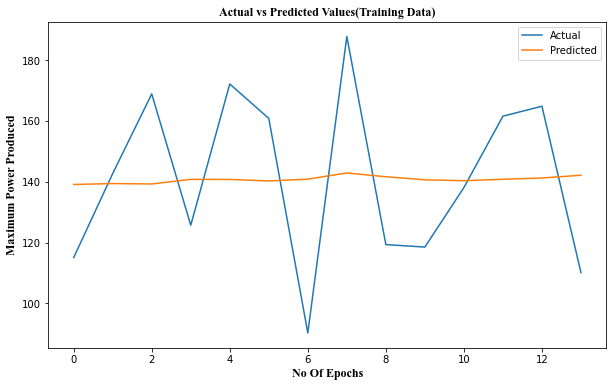

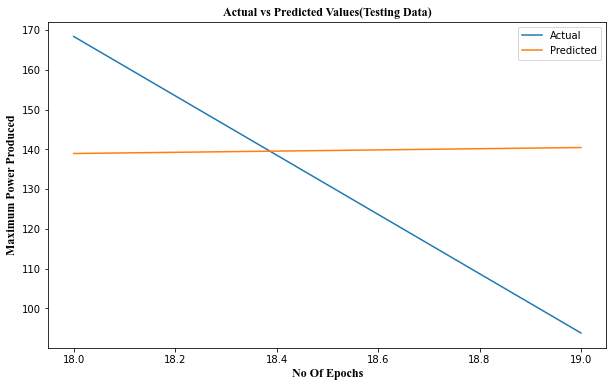

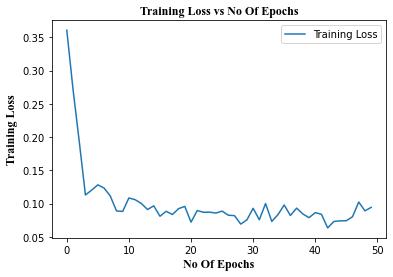

In [62]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size-time_steps], y_train_is, label='Actual')
plt.plot(df.index[:train_size-time_steps], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size+time_steps:], y_test_is, label='Actual')
plt.plot(df.index[train_size+time_steps:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [63]:
results = results.append({"Model_name":"LSTM Neural Network","RMSE": np.sqrt(mse)}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113


# Modular Neural Network

In [64]:


X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

input_shape = (2,)

inputs = layers.Input(shape=input_shape, name="inputs")

x = layers.Dense(12, activation="relu", name="dense1")(inputs)
x = layers.Dense(32, activation="relu", name="dense2")(x)
x = layers.Dense(64, activation="relu", name="dense3")(x)


outputs = layers.Dense(1, activation="linear", name="outputs")(x)

model = keras.Model(inputs=inputs, outputs=outputs, name="modular_nn")

model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.01), loss="mse"
)

history = model.fit(X_train, y_train, epochs=50, batch_size=16, verbose=1, validation_data=(X_test, y_test))






Epoch 1/50
1/1 [==============================] - 1s 645ms/step - loss: 0.3222 - val_loss: 0.0935
Epoch 2/50
1/1 [==============================] - 0s 36ms/step - loss: 0.1011 - val_loss: 0.0289
Epoch 3/50
1/1 [==============================] - 0s 42ms/step - loss: 0.0409 - val_loss: 0.0389
Epoch 4/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0952 - val_loss: 0.0380
Epoch 5/50
1/1 [==============================] - 0s 52ms/step - loss: 0.1015 - val_loss: 0.0245
Epoch 6/50
1/1 [==============================] - 0s 45ms/step - loss: 0.0686 - val_loss: 0.0206
Epoch 7/50
1/1 [==============================] - 0s 42ms/step - loss: 0.0427 - val_loss: 0.0319
Epoch 8/50
1/1 [==============================] - 0s 46ms/step - loss: 0.0398 - val_loss: 0.0495
Epoch 9/50
1/1 [==============================] - 0s 49ms/step - loss: 0.0507 - val_loss: 0.0597
Epoch 10/50
1/1 [==============================] - 0s 51ms/step - loss: 0.0590 - val_loss: 0.0605
Epoch 11/50
1/1 [===========

In [65]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')
print(f'\n')
model.summary()

1/1 [==============================] - 0s 41ms/step
Test Root Mean Squared Error: 13.1353239769
Train Root Mean Squared Error: 16.2083239732


Model: "modular_nn"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 inputs (InputLayer)         [(None, 2)]               0         
                                                                 
 dense1 (Dense)              (None, 12)                36        
                                                                 
 dense2 (Dense)              (None, 32)                416       
                                                                 
 dense3 (Dense)              (None, 64)                2112      
                                                                 
 outputs (Dense)             (None, 1)                 65        
                                                                 
Total params: 2,629
Trainable params: 2,629
N

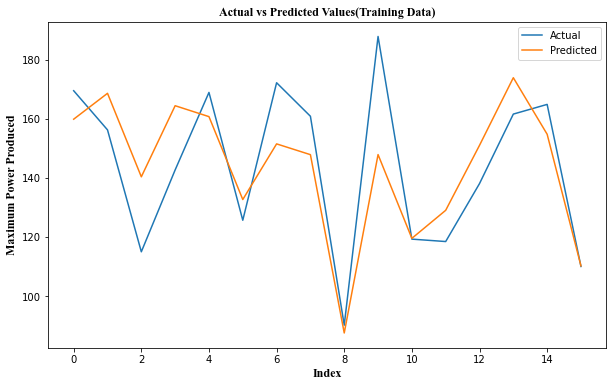

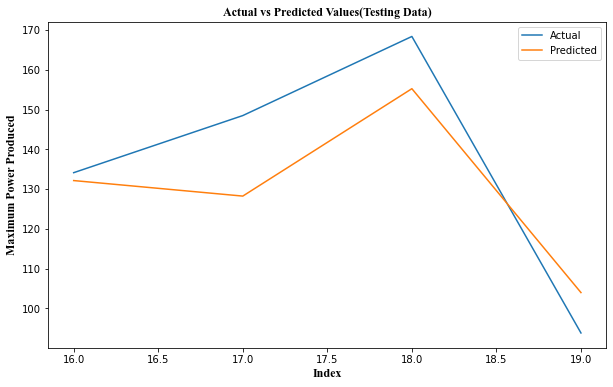

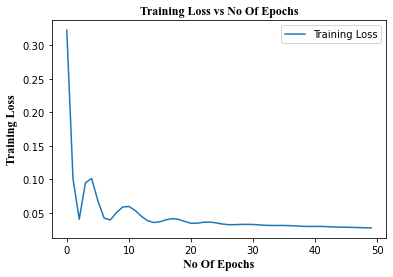

In [66]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("Index", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()


plt.plot(history.history['loss'], label='Training Loss')
plt.title("Training Loss vs No Of Epochs" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Training Loss", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()
plt.show(model)

In [67]:
results = results.append({"Model_name":"Modular Neural Network","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324


# Linear Regression (G and T) 

In [68]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0298216037
Regression equation: Y = P = 0.59T + 0.21IR - 0.10


In [69]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 16.8550456792
Train Root Mean Squared Error: 19.2181888744


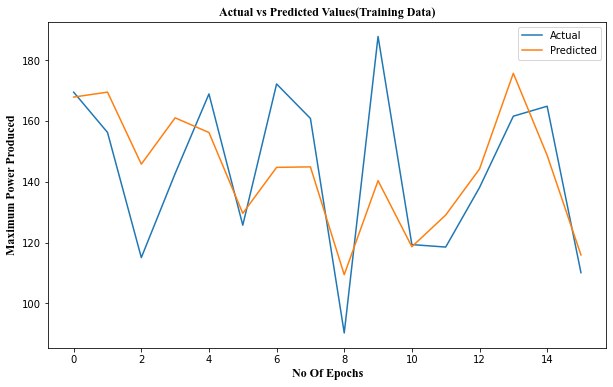

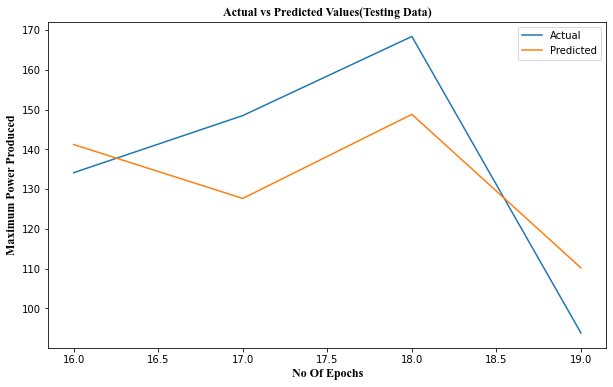

In [70]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [71]:
results = results.append({"Model_name":"Linear Regression(G and T)","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046


# Support Vector Machines

In [72]:
X = df[['Irradiance(W/m2)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



model = SVR(kernel='rbf')

model.fit(X_train, y_train)

y_pred = model.predict(X_test)
mse_5 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_5:.10f}')

Mean Squared Error: 0.0330259942


In [73]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 17.7374991281
Train Root Mean Squared Error: 16.0013896110


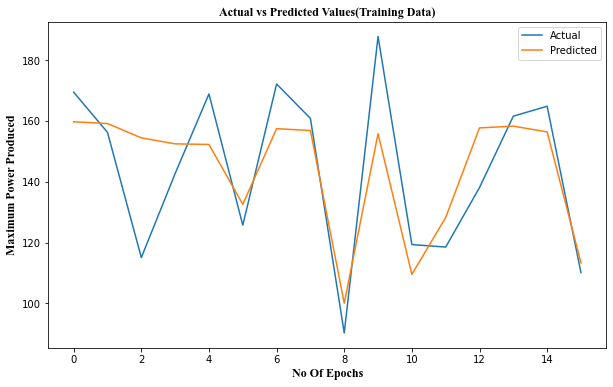

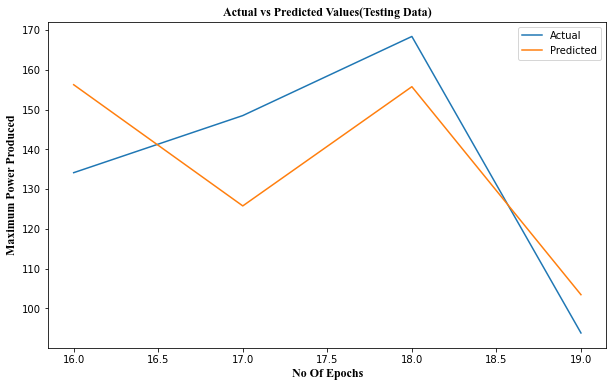

In [74]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [75]:
results = results.append({"Model_name":"Support Vector Machines","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499


# Decision Tree Regressor

In [76]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = DecisionTreeRegressor( max_depth= 50, min_samples_leaf=10)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 28.3945815699
Train Root Mean Squared Error: 27.0129747391


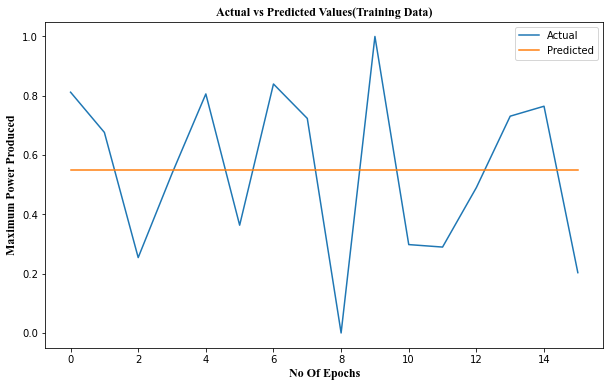

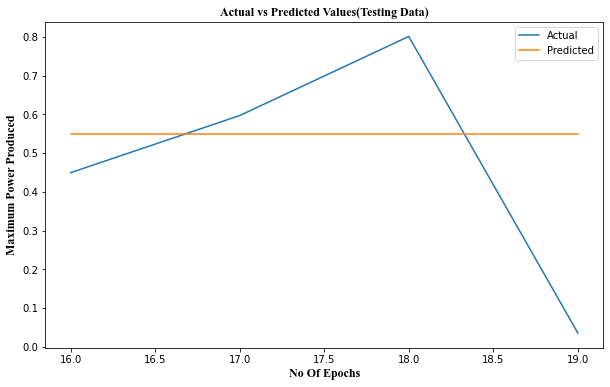

In [77]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [78]:
results = results.append({"Model_name":"Decision Tree Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582


# Random forest regressor

In [79]:



X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

n_estimators = 200  # number of decision trees
model = RandomForestRegressor(n_estimators=n_estimators, max_depth= 50, min_samples_leaf=7)

model.fit(X_train, y_train)

y_pred = model.predict(X_test)

y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

Test Root Mean Squared Error: 28.3935447507
Train Root Mean Squared Error: 27.0013600056


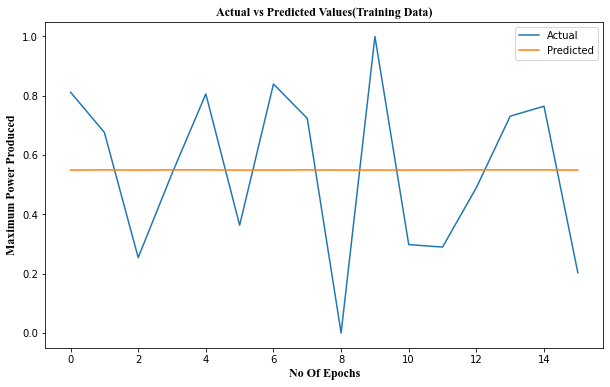

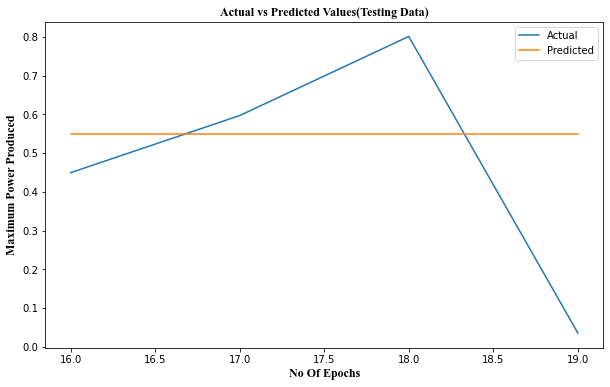

In [80]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y_train, label='Actual')
plt.plot(df.index[:train_size], y_train_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y_test, label='Actual')
plt.plot(df.index[train_size:], y_pred, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [81]:
results = results.append({"Model_name":"Random forest Regressor","RMSE": rmse_1}, ignore_index = True)
results

,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545


# Orthogonal linear regression

In [82]:
X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]

model = OrthogonalMatchingPursuit()
model.fit(X_train, y_train)

y_pred = model.predict(X_test)

rmse = np.sqrt(mean_squared_error(y_test, y_pred))

In [83]:
y_pred = model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')

results = results.append({"Model_name":"Orthogonal linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 19.5190621352


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062


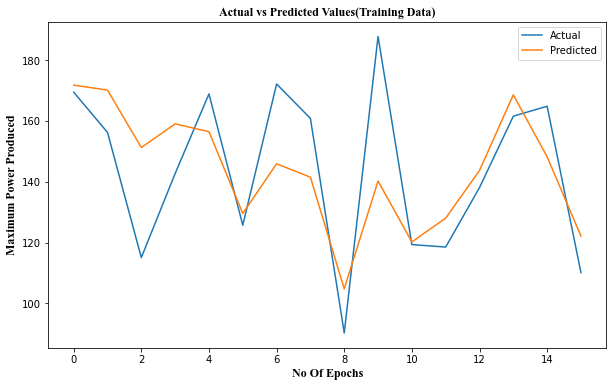

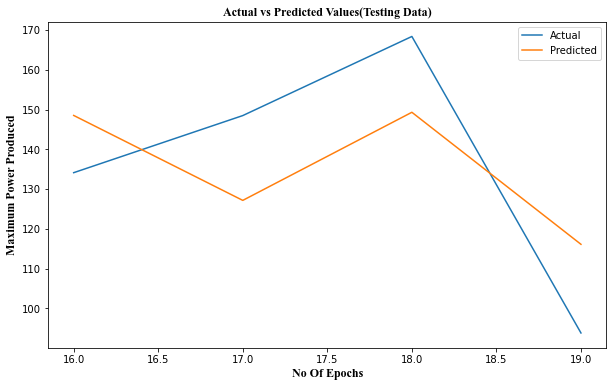

In [84]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Quantile Linear regression

In [85]:
import numpy as np
from sklearn.linear_model import OrthogonalMatchingPursuit
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
import statsmodels.api as sm

X = df.copy()[['Temperature(Â°C)', "Irradiance(W/m2)"]].values
y = df.copy()['Power(Watts)'].values

scaler_X =  MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]


quantile_model = sm.QuantReg(y_train, X_train)
quantile_result = quantile_model.fit(q=0.2)  # Change the quantile value as needed

predicted_power = quantile_result.predict(X)



In [86]:
y_pred = quantile_result.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = quantile_result.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Quantile linear regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 24.6825250236
Train Root Mean Squared Error: 24.1152833125


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062
8,Quantile linear regression,24.682525


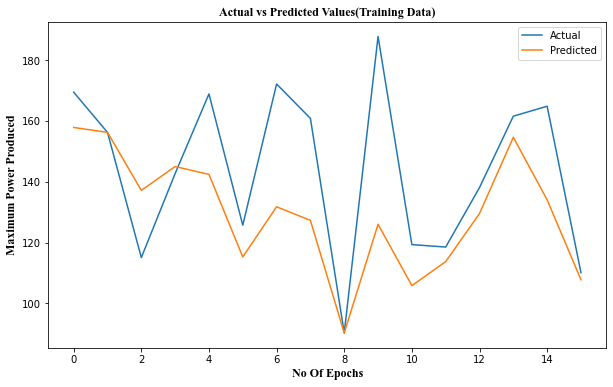

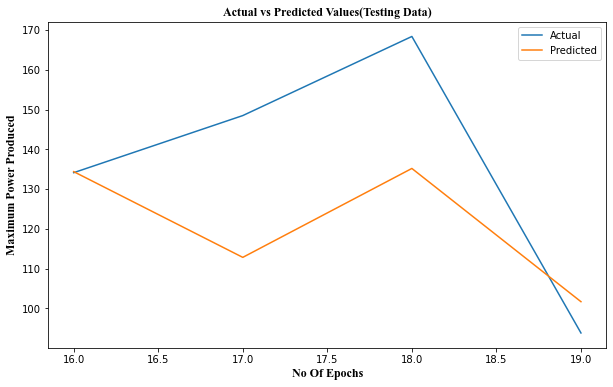

In [87]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T)

In [88]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0309439097
Regression equation: Y = P = 0.23T + 0.55IR^2 - 0.14


In [89]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 17.1692778706
Train Root Mean Squared Error: 19.6515429702


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062
8,Quantile linear regression,24.682525
9,Linear regression(G^2 and T),17.169278


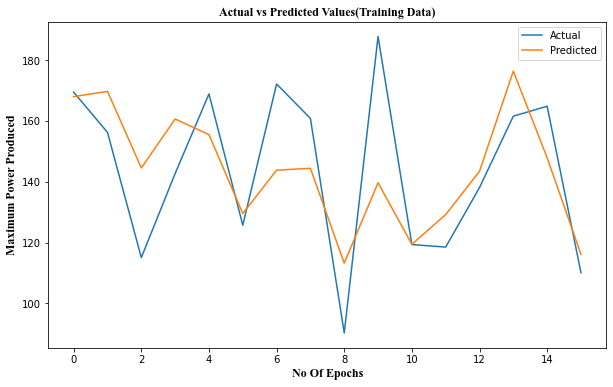

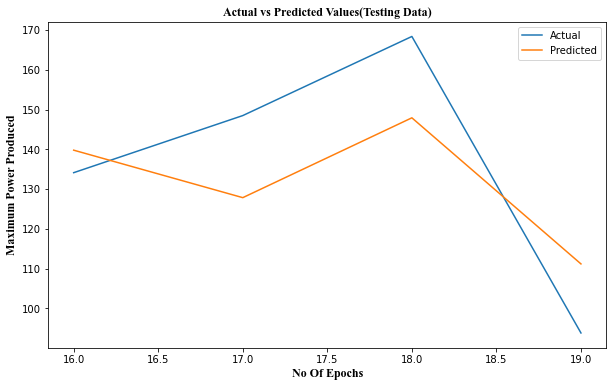

In [90]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G^2 and T^2)

In [91]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X["Irradiance(W/m2)"] = X["Irradiance(W/m2)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0359462120
Regression equation: Y = P = 0.15T + 0.58IR^2 - 0.17


In [92]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G^2 and T^2)","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 18.5050814984
Train Root Mean Squared Error: 19.8225840908


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062
8,Quantile linear regression,24.682525
9,Linear regression(G^2 and T),17.169278


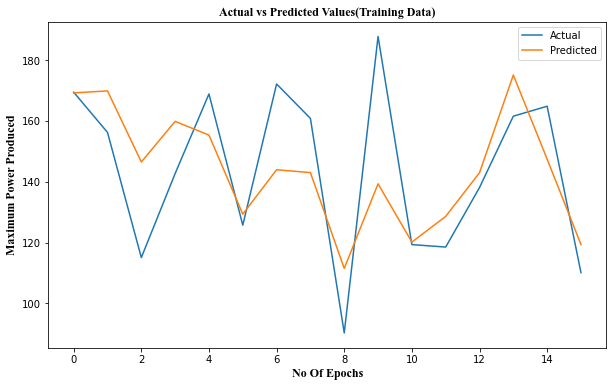

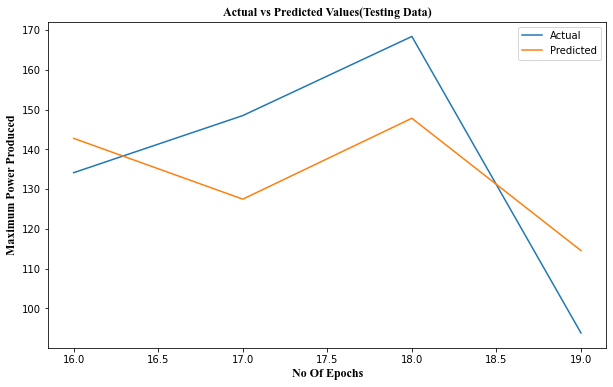

In [93]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Linear Regression(G and T^2)

In [94]:
X = df[['Temperature(Â°C)', 'Irradiance(W/m2)']]
X["Temperature(Â°C)"] = X["Temperature(Â°C)"]**2
X = X.values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = LinearRegression()

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

print("Regression equation: Y = P = {:.2f}T + {:.2f}IR^2 - {:.2f}".format(b[0][0], b[0][1], abs(b0)))

Mean Squared Error: 0.0344477366
Regression equation: Y = P = 0.14T + 0.62IR^2 - 0.13


In [95]:
y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred)

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred)

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Linear regression(G and T^2)", "RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 18.1152687892
Train Root Mean Squared Error: 19.3742713981


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062
8,Quantile linear regression,24.682525
9,Linear regression(G^2 and T),17.169278


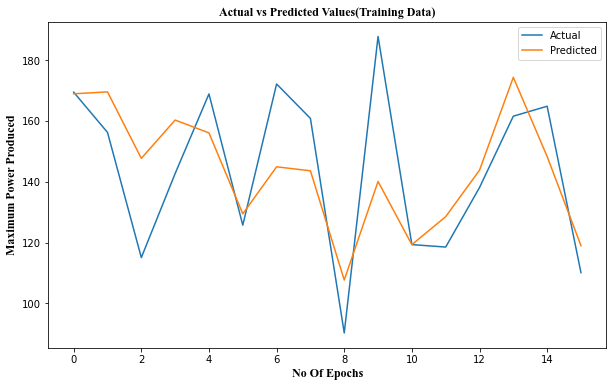

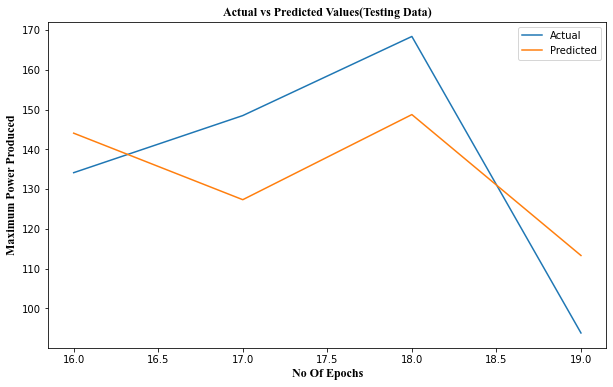

In [96]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Ridge Regression

In [97]:

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = Ridge(alpha=0.3)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)
print(f'Mean Squared Error: {mse_4:.10f}')
b0 = reg_model.intercept_[0]
b = reg_model.coef_

y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Mean Squared Error: 0.0320008815
Test Root Mean Squared Error: 17.4600469544
Train Root Mean Squared Error: 19.4661146615


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062
8,Quantile linear regression,24.682525
9,Linear regression(G^2 and T),17.169278


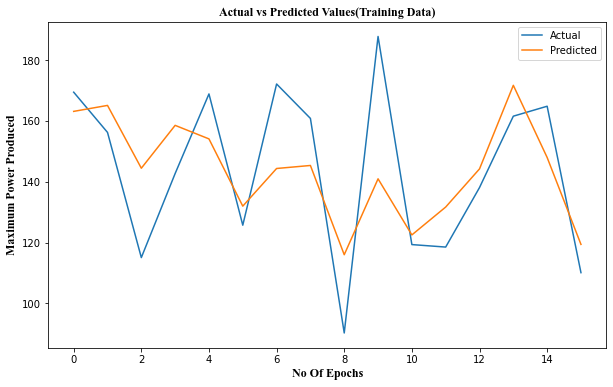

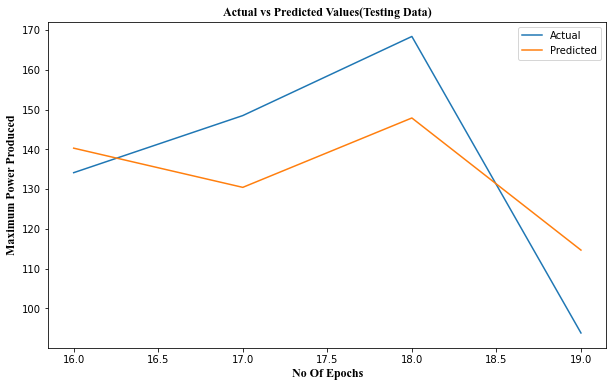

In [98]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

# Kernel Ridge Regression

In [99]:
from sklearn.kernel_ridge import KernelRidge

X = df[[ 'Irradiance(W/m2)', 'Temperature(Â°C)']].values
y = df["Power(Watts)"].values

scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()
X_scaled = scaler_X.fit_transform(X)
y_scaled = scaler_y.fit_transform(y.reshape(-1, 1))

train_size = int(len(df) * 0.8)
X_train, X_test = X_scaled[:train_size], X_scaled[train_size:]
y_train, y_test = y_scaled[:train_size], y_scaled[train_size:]



reg_model = KernelRidge(kernel='rbf', alpha=0.1)

reg_model.fit(X_train, y_train)

y_pred = reg_model.predict(X_test)
mse_4 = mean_squared_error(y_test, y_pred)


y_pred = reg_model.predict(X_test)
y_pred_orig = scaler_y.inverse_transform(y_pred.reshape(-1, 1))

y_train_pred = reg_model.predict(X_train)
y_train_pred_orig = scaler_y.inverse_transform(y_train_pred.reshape(-1, 1))

rmse_1 = np.sqrt(mean_squared_error(y[train_size:], y_pred_orig))

rmse_train = np.sqrt(mean_squared_error(y[:train_size], y_train_pred_orig))

print(f'Test Root Mean Squared Error: {rmse_1:.10f}')
print(f'Train Root Mean Squared Error: {rmse_train:.10f}')

results = results.append({"Model_name":"Kernal Ridge regression","RMSE": rmse_1}, ignore_index = True)
results

Test Root Mean Squared Error: 12.5501267582
Train Root Mean Squared Error: 17.0605402850


,Model_name,RMSE
0,Radial Basis Function Neural Network,59.272905
1,LSTM Neural Network,39.012113
2,Modular Neural Network,13.135324
3,Linear Regression(G and T),16.855046
4,Support Vector Machines,17.737499
5,Decision Tree Regressor,28.394582
6,Random forest Regressor,28.393545
7,Orthogonal linear regression,19.519062
8,Quantile linear regression,24.682525
9,Linear regression(G^2 and T),17.169278


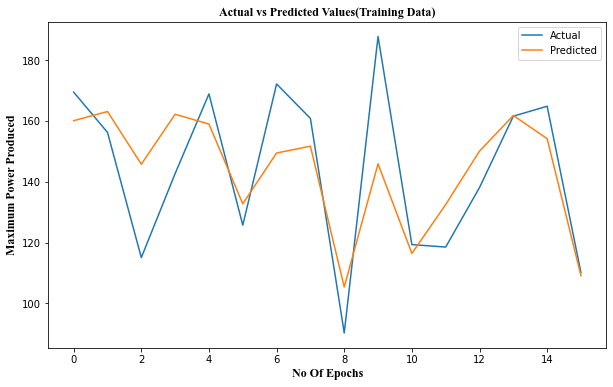

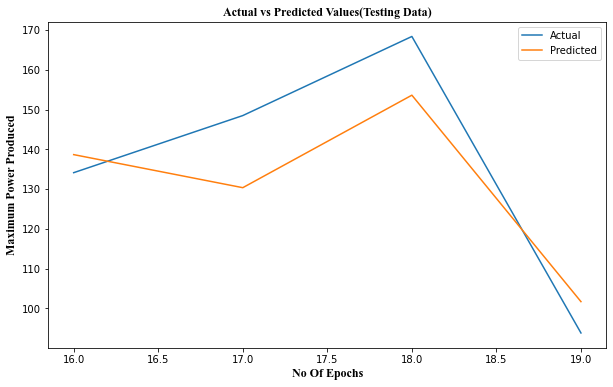

In [100]:
plt.figure(figsize=(10, 6))
plt.plot(df.index[:train_size], y[:train_size], label='Actual')
plt.plot(df.index[:train_size], y_train_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Training Data)", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend()

plt.show()


plt.figure(figsize=(10, 6))
plt.plot(df.index[train_size:], y[train_size:], label='Actual')
plt.plot(df.index[train_size:], y_pred_orig, label='Predicted')
plt.title("Actual vs Predicted Values(Testing Data)" , fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xlabel("No Of Epochs", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.ylabel("Maximum Power Produced", fontname="Times New Roman", fontweight="bold", fontsize=12)
plt.xticks()
plt.yticks()
plt.legend(loc = 'upper right')

plt.show()

In [101]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Kernal Ridge regression,12.550127
1,Modular Neural Network,13.135324
2,Linear Regression(G and T),16.855046
3,Linear regression(G^2 and T),17.169278
4,Ridge regression,17.460047
5,Support Vector Machines,17.737499
6,Linear regression(G and T^2),18.115269
7,Linear regression(G^2 and T^2),18.505081
8,Orthogonal linear regression,19.519062
9,Quantile linear regression,24.682525


In [102]:
results.sort_values("RMSE").reset_index().drop("index", axis = 1)

,Model_name,RMSE
0,Kernal Ridge regression,12.550127
1,Modular Neural Network,13.135324
2,Linear Regression(G and T),16.855046
3,Linear regression(G^2 and T),17.169278
4,Ridge regression,17.460047
5,Support Vector Machines,17.737499
6,Linear regression(G and T^2),18.115269
7,Linear regression(G^2 and T^2),18.505081
8,Orthogonal linear regression,19.519062
9,Quantile linear regression,24.682525
